In [2]:
import pandas as pd
import numpy as np
import math

In [3]:
# Reading and setting date indexes
searches = pd.read_csv("searches.csv")
sales = pd.read_csv("sales.csv")
page_views = pd.read_csv("page_views.csv")

searches.drop("Unnamed: 0",axis=1,inplace=True)
page_views.drop("Unnamed: 0",axis=1,inplace=True)
sales.drop("Unnamed: 0",axis=1,inplace=True)

page_views["date"] = pd.to_datetime(page_views["date"])
searches["date"] = pd.to_datetime(searches["date"])
sales["date"] = pd.to_datetime(sales["date"])

searches.set_index("date",inplace=True)
page_views.set_index("date",inplace=True)
sales.set_index("date",inplace=True)

In [4]:
# searches
# Resampling searches to daily freq
searches = searches.resample("D").sum()
# Checking if there are any missing dates (there are none)
range = pd.date_range(searches.index.min(), searches.index.max(), freq="D")
missing_dates = searches.index[~searches.index.isin(range)]
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq='D')

In [5]:
# page_views
# Checking if there are any missing dates(there are none)
range = pd.date_range(page_views.index.min(), page_views.index.max(), freq="D")
missing_dates = page_views.index[~page_views.index.isin(range)]
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

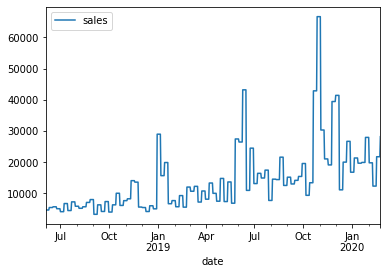

In [6]:
# sales
# Checking if there are any missing dates (there are none)
range = pd.date_range(sales.index.min(), sales.index.max(), freq="W")
missing_dates = sales.index[~sales.index.isin(range)]
missing_dates

# Convert weekly to daily by giving averaging the weekly sale in 7 days
sales = sales.resample("D").ffill()
sales["sales"] = sales["sales"]/7
sales.plot()

# Filling NA values in sales["events"] and one hot-encoding the names 
sales["event"].fillna(value=0, inplace=True)
sales["event"] = sales["event"].map({0:0, "Product Launch":1, "November Sale":2})

In [7]:
# Sales is much longer than searches and page_views, we have to keep the dates closer to today, where we have data on searches and page_views
# but drop the older informations on sales, we don't care about them

# Merging sales on searches, all rows
df1 = sales.merge(searches,how="outer", left_index=True, right_index=True)
# merging df1 on pageveiws, only rows from df1 
df = df1.merge(page_views,how="left", left_index=True, right_index=True)
# dropping the old sales info where we dont have analytics
df = df.dropna(subset=["organic_searches","page_views"])

In [8]:
# creating a logical training - test split on the database
def some(x):
    if math.isnan(x):
        return 1
    else:
        return 0
df["test"] = df["sales"].apply(some)

In [20]:
# Confining the sales with this weird log notation
# log(((x + offset) - a)/(b - (x + offset))) where a is lower limit and b is upper limit
def log_interval_vec(x,limit_lower=0,offset=1):
    #the upper value is max of the column + 10%
    upper_limit = df["sales"].max() + ((df["sales"].max() / 100)*10)
    return np.log(((x + offset) - limit_lower)/(upper_limit - (x + offset)))

df["sales_trans"] = df["sales"].apply(log_interval_vec)

# then we standardize_vec the sales to bring the mean to 0 and std to 1 
from sklearn.preprocessing import StandardScaler
df['sales_norm'] = StandardScaler().fit_transform(df[['sales_trans']])

In [31]:
# we log1p organic_searches and page_views with the log
df['searches_log'] = np.log1p(df[['organic_searches']])
df['views_log'] = np.log1p(df[['page_views']])

# we standardize the mean and the std
df['searches_norm'] = StandardScaler().fit_transform(df[['searches_log']])
df['views_norm'] = StandardScaler().fit_transform(df[['views_log']])

In [33]:
df["event"].is

,sales,event,organic_searches,page_views,test,sales_trans,sales_norm,searches_log,views_log,searches_norm,views_norm
date,,,,,,,,,,,
2019-05-08,7384.829172,0.0,482.0,1664.0,0,-2.189490,-1.477230,6.180017,7.417580,1.425727,-0.250890
2019-05-09,7384.829172,0.0,529.0,1632.0,0,-2.189490,-1.477230,6.272877,7.398174,1.716729,-0.288902
2019-05-10,7384.829172,0.0,413.0,2428.0,0,-2.189490,-1.477230,6.025866,7.795235,0.942657,0.488840
2019-05-11,7384.829172,0.0,259.0,1154.0,0,-2.189490,-1.477230,5.560682,7.051856,-0.515117,-0.967252
2019-05-12,13670.120078,0.0,308.0,1304.0,0,-1.473628,-0.592472,5.733341,7.173958,0.025956,-0.728084
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27,NaN,NaN,472.0,16860.0,1,NaN,NaN,6.159095,9.732759,1.360165,4.283957
2020-02-28,NaN,NaN,353.0,8362.0,1,NaN,NaN,5.869297,9.031572,0.452008,2.910511
2020-02-29,NaN,NaN,202.0,2891.0,1,NaN,NaN,5.313206,7.969704,-1.290645,0.830579
